# Market Price Estimation — BMW cars' auctions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
from scipy.stats import levene

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA


from datetime import datetime
import time
import warnings

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

## Introduction

The B2B automobile auction dataset gathers around 5k BMW cars sold in 2018. Besides the registration date (the date when the cars where initially sold and put into circulation), the dataset has complete features ranging from car type, to fuel, paint color, model, mileage, eight other equipement features tagged 'feature_1' to 'feature_8' and of course, price.

For starters, this work will aim to assess which are the most determinant features that influence the price of a car at the time of an auction. Our methodology will consist in comparing different regression models such as linear regressions, random forest and gradient boosting. Then, the focus will be put into a broad analysis of inferences using time-series modeling tools primarly. This will settle the ground for a forecast analysis based on a plausible client scenario that will be explained further on.

### 1. Exploratory Data Analysis

To begin with, we will search for straighforward insights such as distributions and other KPI as a way of understanding the shape and the logic of how the data was gathered and parsed;  also as a means of problematizing our subject. 



In [2]:
df_raw = pd.read_csv("auctions.csv")
df = df_raw.copy()

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   maker_key          4843 non-null   object
 1   model_key          4843 non-null   object
 2   mileage            4843 non-null   int64 
 3   engine_power       4843 non-null   int64 
 4   registration_date  4843 non-null   object
 5   fuel               4843 non-null   object
 6   paint_color        4843 non-null   object
 7   car_type           4843 non-null   object
 8   feature_1          4843 non-null   bool  
 9   feature_2          4843 non-null   bool  
 10  feature_3          4843 non-null   bool  
 11  feature_4          4843 non-null   bool  
 12  feature_5          4843 non-null   bool  
 13  feature_6          4843 non-null   bool  
 14  feature_7          4843 non-null   bool  
 15  feature_8          4843 non-null   bool  
 16  price              4843 non-null   int64 


In [4]:
df_raw.head()

,maker_key,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,BMW,118,140411,100,2/1/2012,diesel,black,convertible,True,True,False,False,True,True,True,False,11300,1/1/2018
1,BMW,M4,13929,317,4/1/2016,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700,2/1/2018
2,BMW,320,183297,120,4/1/2012,diesel,white,convertible,False,False,False,False,True,False,True,False,10200,2/1/2018
3,BMW,420,128035,135,7/1/2014,diesel,red,convertible,True,True,False,False,True,True,True,True,25100,2/1/2018
4,BMW,425,97097,160,12/1/2014,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400,4/1/2018


There are 5 categorical columns, 3 numerical columns (including price), 8 booleans and 2 date format columns.

In [5]:
columns = ['maker_key', 'model_key', 'fuel', 'paint_color', 'car_type']

def description(columns):
    result = []
    for column in columns:
        result.append(f"There are {df[column].nunique()} different {column}s.\n")
    return result

descriptions = description(columns)
for desc in descriptions:
    print(desc)

There are 1 different maker_keys.

There are 75 different model_keys.

There are 4 different fuels.

There are 10 different paint_colors.

There are 8 different car_types.



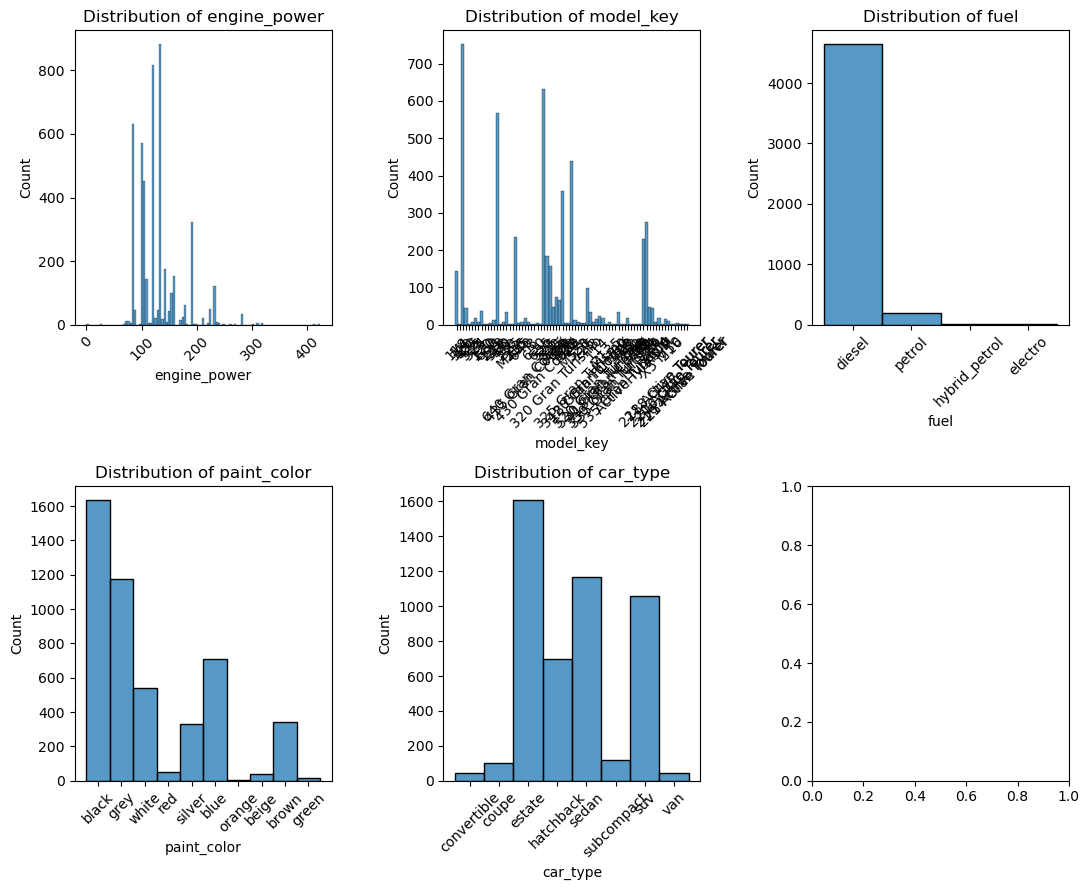

In [6]:
mets = ['engine_power', 'model_key', 'fuel', 'paint_color', 'car_type']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(11, 9))

axes = axes.flatten()

for i, metric in enumerate(mets):
    ax = axes[i]
    sns.histplot(data=df, x=metric, ax=ax)
    ax.set_title(f"Distribution of {metric}")
    ax.tick_params(axis='x', rotation=45)  # Set x-axis tick labels rotation

plt.tight_layout()
plt.show()

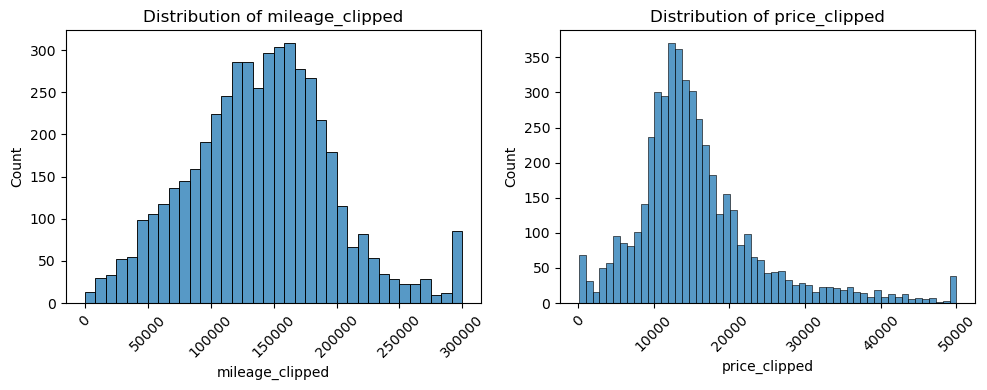

In [7]:
df_1 = df_raw.copy()
df_1["mileage_clipped"]= df_1['mileage'].clip(upper=300000)
df_1["price_clipped"]= df["price"].clip(upper=50000)

mets_1 = ['mileage_clipped', 'price_clipped']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes = axes.flatten()

for i, metric in enumerate(mets_1):
    ax = axes[i]
    sns.histplot(data=df_1, x=metric, ax=ax)
    ax.set_title(f"Distribution of {metric}")
    ax.tick_params(axis='x', rotation=45)  

plt.tight_layout()
plt.show()

In [8]:
expensive_cars = df[df['price'] > 50000]
print(f"There are {len(expensive_cars)} expensive cars (more than 50k dollars)")

There are 32 expensive cars (more than 50k dollars)


In [9]:
high_milers = df[df['mileage'] > 300000]
print(f"There are {len(high_milers)} high milers (more than 300k miles)")

There are 76 high milers (more than 300k miles)


In [10]:
print('The most expensive car costs ' + str(df["price"].max()) + ' dollars')
print('The oldest car is from ' + str(df['registration_date'].min()))
print('The most recent car is from ' + str(df['registration_date'].max()))

f"There have been {df['sold_at'].nunique()} different auction dates, all the same week."

The most expensive car costs 178500 dollars
The oldest car is from 1/1/1994
The most recent car is from 9/1/2016


'There have been 9 different auction dates, all the same week.'

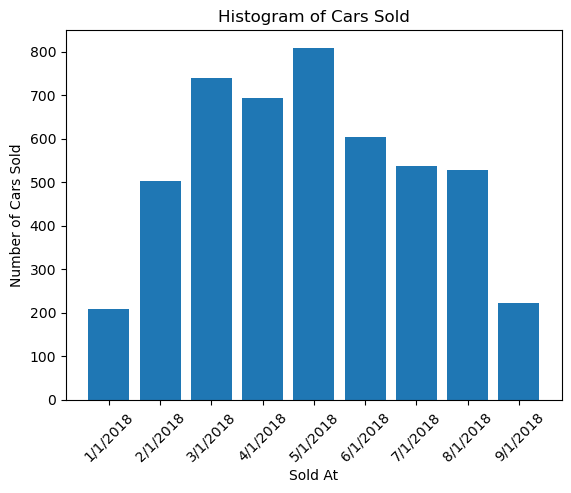

In [11]:
sold_at_counts = df['sold_at'].value_counts().sort_index()

plt.bar(sold_at_counts.index, sold_at_counts.values)
plt.xlabel('Sold At')
plt.ylabel('Number of Cars Sold')
plt.title('Histogram of Cars Sold')
plt.xticks(rotation=45) 
plt.show()

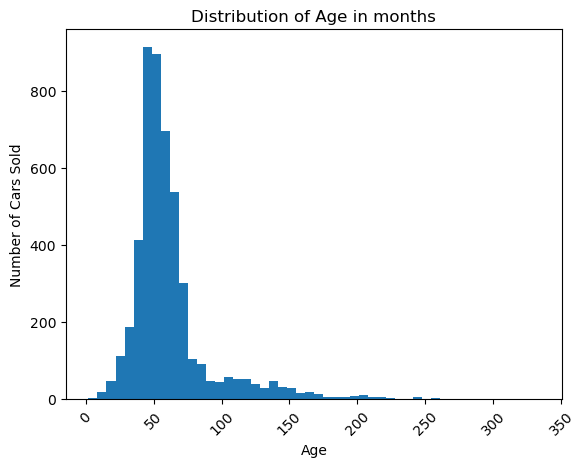

In [12]:
registration_counts = df['registration_date'].value_counts().sort_index()
df["registration_date"] = pd.to_datetime(df["registration_date"])

fixed_date = pd.to_datetime('1/1/2018')
df["age"] = (fixed_date.year - df["registration_date"].dt.year) * 12 + (fixed_date.month - df["registration_date"].dt.month)

age_distribution = df['age'].value_counts().sort_index()
plt.hist(df['age'], bins=50)
plt.xlabel('Age')
plt.ylabel('Number of Cars Sold')
plt.title('Distribution of Age in months')
plt.xticks(rotation=45)
plt.show()

### 2. Price analysis using regression models

The relation between pricing and the other features in the dataset is not simple to determine based on our previous analysis.
We will now use Machine Learning algorithms to model the relation between the car's features (features) and their price (target).

Our goal at this stage, is to privilege readability rather than performance, meaning that stock algorithms such as scikit-learn's linear regression, random forest and xgboost, which are among the most popular, should suffice.

#### 2.1. Setup

_2.1.1. Data cleaning_

At the moment of splitting our data into training and testing sets, we need to eliminate categories that have only one item in 'model_key' column. But beforehand we must be sure that the dataset will keep the same relation with reality upon cleaning. 

We will test if the elimination of those items has a statistically significant impact.

In [13]:
df_test = df_raw.copy()
df_test_counts = df_test['model_key'].value_counts()
df_test_trunc = df_test[df_test['model_key'].isin(df_test_counts[df_test_counts > 1].index)]

In [14]:
t_statistic, p_value = ttest_ind(df_test_trunc['price'], df_test['price'], equal_var=False)

print("T-test pour la colonne 'price':")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Différence statistiquement significative dans les moyennes\n")
else:
    print("Pas de différence statistiquement significative dans les moyennes\n")

T-test pour la colonne 'price':
T-statistic: -0.11057626011275971
P-value: 0.9119546680317866
Pas de différence statistiquement significative dans les moyennes



In [15]:
levene_statistic, p_value = levene(df_test_trunc['price'], df_test['price'])

print("Statistiques pour la colonne 'price':")
print(f"Levene stat: {levene_statistic}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Différence statistiquement significative dans les écart-types\n")
else:
    print("Pas de différence statistiquement significative dans les écart-types\n")

Statistiques pour la colonne 'price':
Levene stat: 0.019484686430782598
P-value: 0.8889887778099471
Pas de différence statistiquement significative dans les écart-types



We are now shure that we can get rid of single item categories.

In [16]:
df_counts = df['model_key'].value_counts()
selected_indices = df_counts[df_counts > 1].index
df = df[df['model_key'].isin(selected_indices)]

_2.1.1. Preprocessing pipeline_

In [17]:
numerical_feats = ['mileage', 'engine_power', 'age']
categorical_feats = ['model_key', 'fuel', 'paint_color', 'car_type']
boolean_feats = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8']


In [18]:
scaler = StandardScaler()
dummifier = OneHotEncoder()

In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', scaler, numerical_feats),
        ('categorical', dummifier, categorical_feats)
    ],
    remainder='passthrough'
)

_2.1.2. X, y split_

In [20]:
X = df.drop(
    columns=[
        'price', 'sold_at', 'maker_key', 'registration_date'
        ])
        
y = df[["price"]]

_2.1.3. Test/Train split_

In [21]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=43)

_2.1.4. Model selection_

In [22]:
models = [
    #LinearRegression(),
    Ridge(),
    Lasso(),
    RandomForestRegressor(n_estimators=100, random_state=43),
    xgb.XGBRegressor()
    
]

#### 2.2 Model implementation

_2.2.1. Actual preprocessing_

In [23]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

_2.2.1. Training pipeline_

In [24]:
for model in models:
    start = time.time()
    model.fit(X_train,y_train)
    end = time.time()
    print(type(model).__name__)
    print("")
    print("Time : {:.4f} sec".format(end-start))
    print("Train Score : {:.3f} , Test Score : {:.3f}".format(model.score(X_train,y_train), model.score(X_test,y_test)))
    print("Root mean square error : {:.0f}".format(mean_squared_error(y_test,model.predict(X_test))**(1/2)))
    print(40*"—")

Ridge

Time : 0.0200 sec
Train Score : 0.794 , Test Score : 0.610
Root mean square error : 6342
————————————————————————————————————————


Lasso

Time : 0.4375 sec
Train Score : 0.795 , Test Score : 0.611
Root mean square error : 6334
————————————————————————————————————————


/var/folders/m9/3g_k5s8d6wl58hbz0vy59zkc0000gn/T/ipykernel_22799/2521573251.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,y_train)


RandomForestRegressor

Time : 6.7806 sec
Train Score : 0.978 , Test Score : 0.673
Root mean square error : 5807
————————————————————————————————————————
XGBRegressor

Time : 0.1811 sec
Train Score : 0.975 , Test Score : 0.631
Root mean square error : 6168
————————————————————————————————————————


_2.2.2. Fine tuning and crossvalidation using gridsearch_

In [25]:
# Linear Regressions

LR_parameters = {
    "alpha":[0.001, 0.01, 0.1, 1, 3, 6, 10, 50, 100]
}

In [26]:
# RandomForestRegressor

RF_parameters = {
    "n_estimators": [200,300],
    "max_depth": [10, 20],
    "min_samples_split": [5,10],
    "min_samples_leaf": [1,3]
}

In [27]:
# XGBoostRegressor

XGB_parameters = {
    'n_estimators': [200,300],
    'max_depth': [1,2,4],
    'gamma':[0,0.1,0.2]

}

In [28]:
param_grids = [LR_parameters, LR_parameters, RF_parameters, XGB_parameters]


for model, param_grid in zip(models, param_grids):
    start = time.time()
    warnings.filterwarnings("ignore")

    # Perform GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2')
    grid_search.fit(X_train, y_train)

    end = time.time()

    
    print(type(model).__name__)
    print("Time: {:.4f} sec".format(end - start))
    print('')
    print("Best Parameters:", grid_search.best_params_)
    print("Best R2-Score (r2):", grid_search.best_score_)
    
    best_model = grid_search.best_estimator_

    print("Train Score: {:.3f}, Test Score: {:.3f}".format(
        best_model.score(X_train, y_train), best_model.score(X_test, y_test)))
    
    y_pred = best_model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print("Root Mean Square Error: {:.0f}".format(rmse))
    
    print(40 * "—")

Ridge
Time: 0.4010 sec

Best Parameters: {'alpha': 1}
Best R2-Score (r2): 0.7730184814917996
Train Score: 0.794, Test Score: 0.610
Root Mean Square Error: 6342
————————————————————————————————————————
Lasso
Time: 6.0813 sec

Best Parameters: {'alpha': 1}
Best R2-Score (r2): 0.7720233310790895
Train Score: 0.795, Test Score: 0.611
Root Mean Square Error: 6334
————————————————————————————————————————
RandomForestRegressor
Time: 293.7056 sec

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best R2-Score (r2): 0.8403420309175713
Train Score: 0.958, Test Score: 0.671
Root Mean Square Error: 5821
————————————————————————————————————————
XGBRegressor
Time: 8.5037 sec

Best Parameters: {'gamma': 0, 'max_depth': 2, 'n_estimators': 300}
Best R2-Score (r2): 0.8429539905992337
Train Score: 0.913, Test Score: 0.651
Root Mean Square Error: 5998
————————————————————————————————————————


#### 2.4. Feature importance extraction using Lasso

In [29]:
categorical_column_names = preprocessor.transformers_[1][1].categories_
numerical_column_names = X.loc[:, numerical_feats].columns
column_names = list(X.columns)
boolean_column_names = [col for col in column_names if X[col].dtype == bool]

In [30]:
all_column_names = []
flat_categorical_column_names = np.concatenate(categorical_column_names)
all_column_names = np.append(flat_categorical_column_names, numerical_column_names)
all_column_names = np.append(all_column_names, boolean_column_names)

In [31]:
regressor = Lasso(alpha=200.0)
regressor.fit(X_train, y_train)
feature_importance_coef = regressor.coef_

In [32]:
feature_importance = pd.DataFrame({
    "feature_names": all_column_names,
    "coefficients":feature_importance_coef.flatten()
})


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, '116'),
  Text(1, 0, 'feature_1'),
  Text(2, 0, 'feature_8'),
  Text(3, 0, 'feature_4'),
  Text(4, 0, 'engine_power'),
  Text(5, 0, 'X6'),
  Text(6, 0, 'feature_3'),
  Text(7, 0, 'feature_2')])

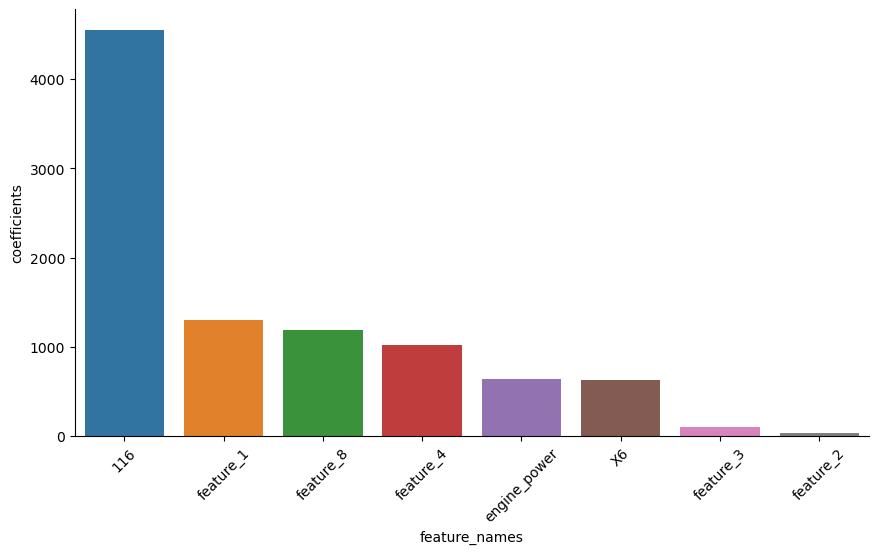

In [33]:
sns.catplot(x="feature_names", 
            y="coefficients", 
            data=feature_importance.sort_values(by="coefficients", ascending=False).head(8), 
            kind="bar",
            aspect=16/9)

# rotate the x-axis labels
plt.xticks(rotation=45)

### 3. Time Series Analysis

The BWM auction Dataset has a column that indicates the date of every car's registration. Assuming that the registration of a car is done at the moment when it's initially brand new purchased. We can thus do a Time Series Analysis.

#### 3.1. Setup

_3.1.1. Series setup and test/train split_

In [34]:
df_time = df_raw[['registration_date', 'price']].rename(columns={'registration_date': 'date'}).set_index('date').sort_index(ascending=True)
df_time.index = pd.to_datetime(df_time.index)

<Axes: xlabel='date', ylabel='price'>

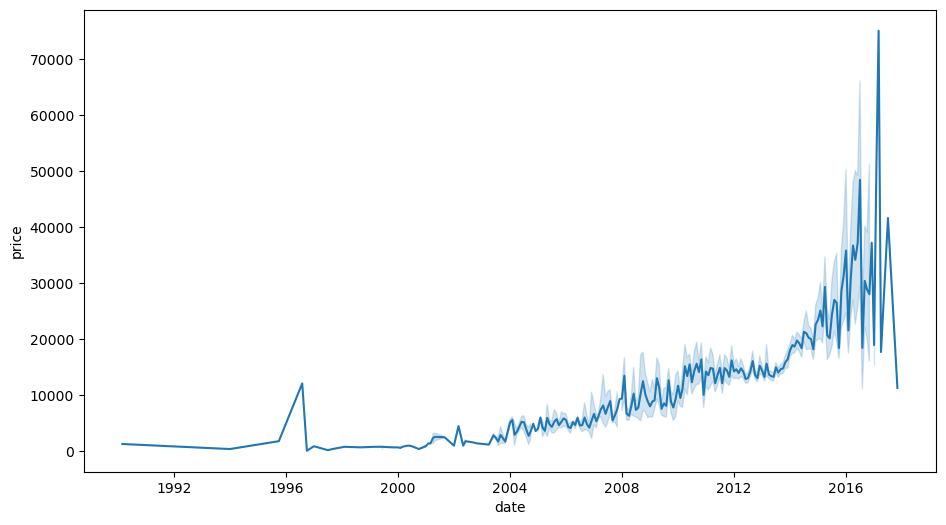

In [35]:
plt.figure(figsize=(11, 6))
sns.lineplot(data=df_time, x='date', y='price')

#### 3.2. Assessing data stationnarity

_3.2.1. ADFuller testing_

In [36]:
def adfuller_test(timeseries):
    print ('Results of the Dickey-Fuller Test:')

    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','P-Value','Number of Lags Used','Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print (dfoutput)

In [37]:
full_series = df_time.squeeze()

In [38]:
adfuller_test(full_series)

Results of the Dickey-Fuller Test:
Test Statistic                -1.227771e+01
P-Value                        8.358978e-23
Number of Lags Used            1.100000e+01
Number of Observations Used    4.831000e+03
Critical Value (1%)           -3.431704e+00
Critical Value (5%)           -2.862138e+00
Critical Value (10%)          -2.567089e+00
dtype: float64


Upon Dickey-Fuller testing, with a p-value way lower than 0.05 and similar ADFStat and critical values, we can reject the null hypothesis thus concluding that the time series is stationary.

In [39]:
rolling_mean = df_time.rolling(window = 5).mean()
rolling_std = df_time.rolling(window=5).std()

<Axes: xlabel='date'>

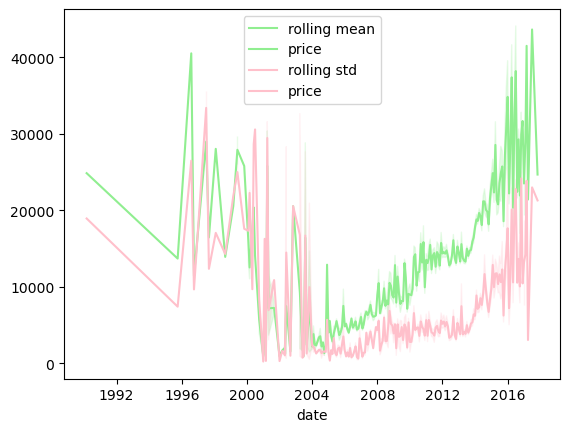

In [40]:
sns.lineplot(rolling_mean, palette = ['lightgreen'], label = 'rolling mean')
sns.lineplot(rolling_std, palette = ['pink'], label = 'rolling std')

Though, it is easy to see that that statement is shabby. There are clearly two phases in our timeline. Between 1994 and 2004 there are too few cars that were registered showing a chaotic lineplot. After 2005 we see a more stable tendency. Let's then resample.

In [41]:
df_short = df_time[df_time.index >= '2005-01-01']
series = df_short.squeeze()


In [43]:
adfuller_test(series)

Results of the Dickey-Fuller Test:
Test Statistic                -1.249038e+01
P-Value                        2.954581e-23
Number of Lags Used            1.100000e+01
Number of Observations Used    4.735000e+03
Critical Value (1%)           -3.431732e+00
Critical Value (5%)           -2.862151e+00
Critical Value (10%)          -2.567095e+00
dtype: float64


<Axes: xlabel='date'>

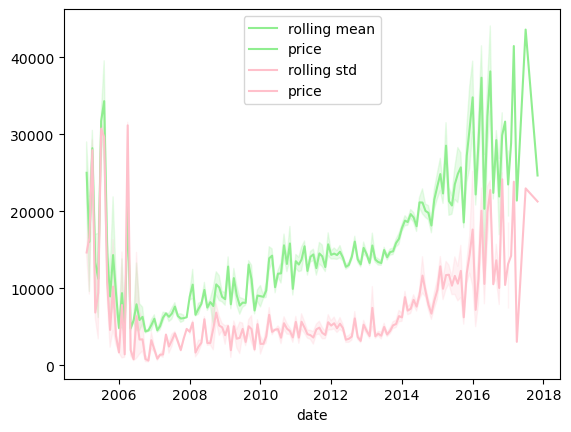

In [52]:
rolling_mean = df_short.rolling(window = 5).mean()
rolling_std = df_short.rolling(window=5).std()

sns.lineplot(rolling_mean, palette = ['lightgreen'], label = 'rolling mean')
sns.lineplot(rolling_std, palette = ['pink'], label = 'rolling std')

_3.2.2. Differentiation and autocorrelation visualisation_

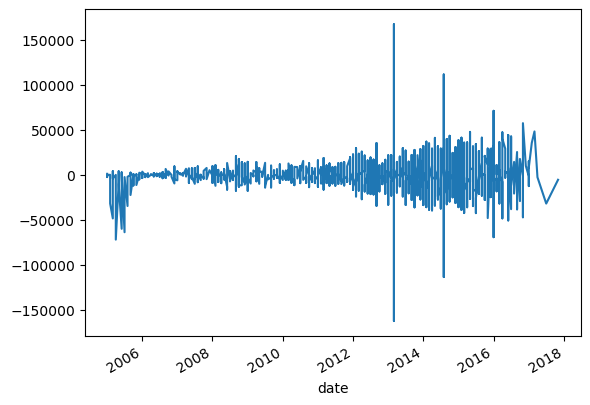

In [53]:
series.diff().plot()
plt.show()

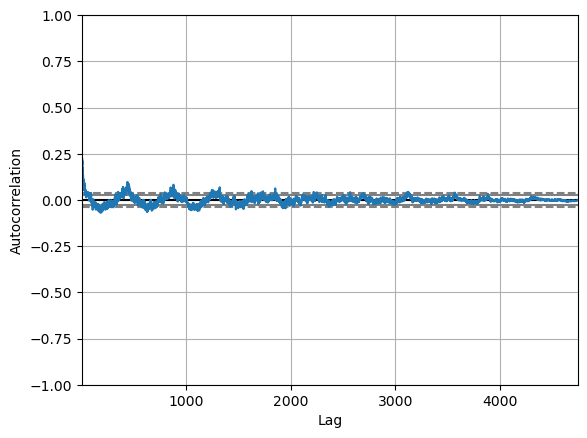

In [54]:
pd.plotting.autocorrelation_plot(series)
plt.show()

_3.2.3. Naive decomposition_

In [59]:
decomp_series = seasonal_decompose(df_short, model='additive', period=7)

<Axes: title={'center': 'Trend'}, xlabel='date'>

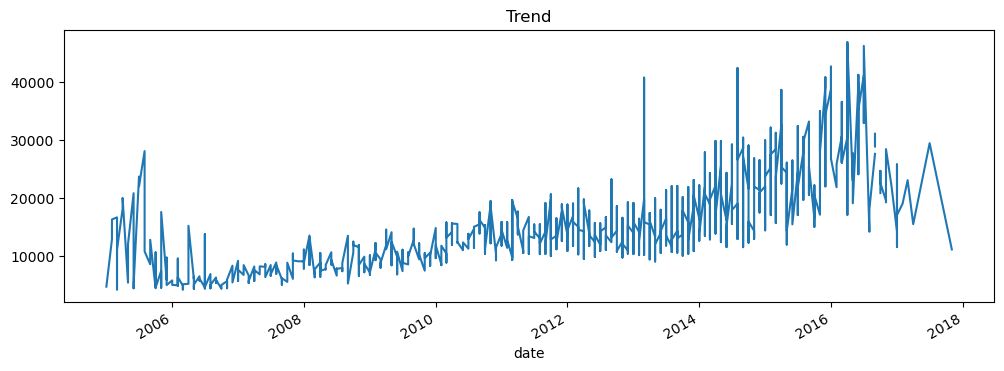

In [60]:
trend = decomp_series.trend
seasonal = decomp_series.seasonal
residual = decomp_series.resid

trend.plot(figsize=(12, 4), title='Trend')

<Axes: title={'center': 'Seasonal'}, xlabel='date'>

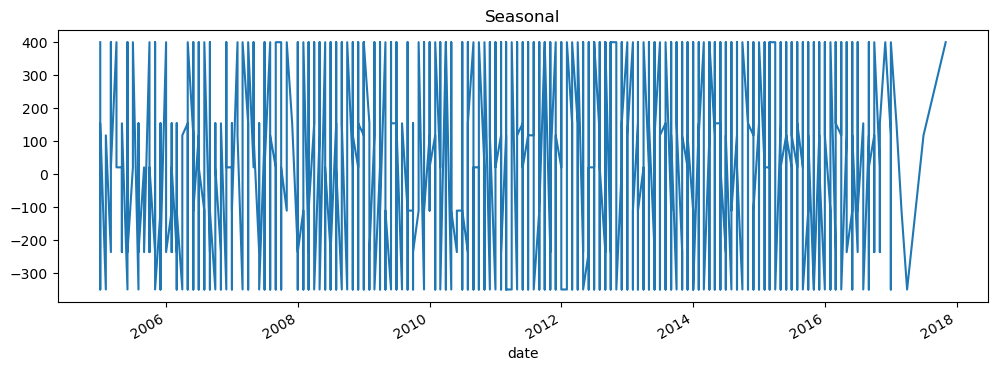

In [61]:
seasonal.plot(figsize=(12, 4), title='Seasonal')

<Axes: title={'center': 'Residual'}, xlabel='date'>

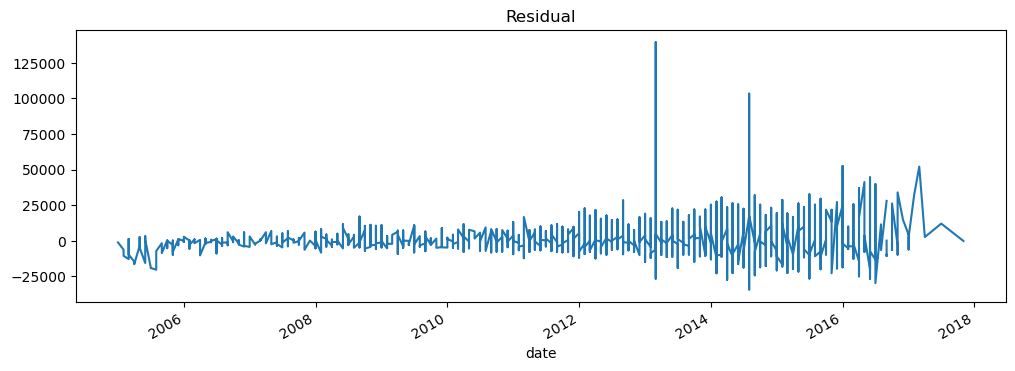

In [62]:
residual.plot(figsize=(12, 4), title='Residual')

#### 3.3. Building an ARIMA model

_3.3.1. Train/test split_

In [64]:
train_size = round(df_time.shape[0] * 0.85)
train_set = df_time.iloc[:train_size, :]
test_set = df_time.iloc[train_size:, :]

_3.3.2. Model implementation_

In [66]:

train_series = train_set.squeeze()

# fit model
arima_model = ARIMA(train_series, order=(2,1,3))
arima_model_fit = arima_model.fit()

In [67]:
one_step_forecast = arima_model_fit.forecast()
y_pred = one_step_forecast.values[0]
y_true = test_set.iloc[0, 0]
error = np.sqrt((y_true - y_pred)**2)

print(f"Forecast: {y_pred}")
print(f"Real value: {y_true}")
print(f"Error: {error}")

Forecast: 7775.103693415314
Real value: 5100
Error: 2675.1036934153144


In [92]:
one_year_forecast = arima_model_fit.forecast(steps=365)
print(one_year_forecast.iloc[-1])

7708.022411084672


### 4.1. Prediction

Now we want to find a car model worth 20k dollars that will be used for 10k miles approximatly and then sold one year after the purchase. Our objective is to minimize the loss in value.

In [115]:
budget = 20000
in_budget = df[(df['price'] >= 20000) & (df['price'] <= 30000)]

In [124]:
in_budget.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 677 entries, 3 to 4841
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   maker_key          677 non-null    object        
 1   model_key          677 non-null    object        
 2   mileage            677 non-null    int64         
 3   engine_power       677 non-null    int64         
 4   registration_date  677 non-null    datetime64[ns]
 5   fuel               677 non-null    object        
 6   paint_color        677 non-null    object        
 7   car_type           677 non-null    object        
 8   feature_1          677 non-null    bool          
 9   feature_2          677 non-null    bool          
 10  feature_3          677 non-null    bool          
 11  feature_4          677 non-null    bool          
 12  feature_5          677 non-null    bool          
 13  feature_6          677 non-null    bool          
 14  feature_7

In [127]:
df_clean = df.drop(df.index)